In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2 as cv
from google.colab.patches import cv2_imshow
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

# **Tugas Praktikum**

### **1. Gamma Correction**

 Gamma Correction pada citra 
-----------------------------
Masukkan nilai Gamma: 3


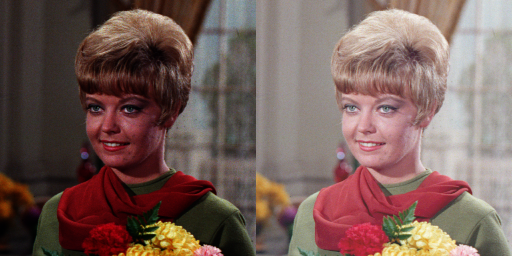

In [3]:
print(' Gamma Correction pada citra ')
print('-----------------------------')
try:
  gamma = int(input('Masukkan nilai Gamma: '))
except ValueError:
  print('Error, not a number')

original = cv.imread('/content/drive/MyDrive/Images/female.tiff')

def gamma_correction(image, gamma):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv.LUT(image, table)

gamma_correction_image = gamma_correction(original, gamma)

final_frame = cv.hconcat((original, gamma_correction_image))
cv2_imshow(final_frame)

### **2. Image Depth**

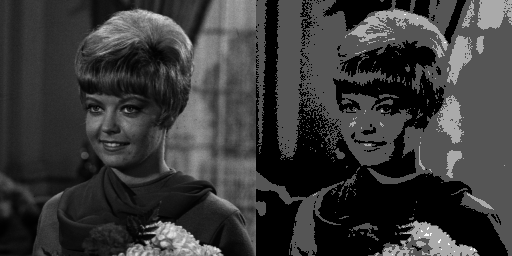

In [4]:
bit_depth=2
level = 255 / (pow(2,bit_depth)-1)
original = cv.imread('/content/drive/MyDrive/Images/female.tiff', cv.IMREAD_GRAYSCALE)
depth_image = np.zeros(original.shape, original.dtype)

# Mengubah kedalaman bit gambar
depth_image = np.round(original / level) * level

# Konversi gambar ke dalam rentang 0-255 (jika tidak sudah dalam range tersebut)
depth_image = np.clip(depth_image, 0, 255)

final_frame = cv.hconcat([original, depth_image.astype(np.uint8)])
cv2_imshow(final_frame)

### **3. Average Denoising**

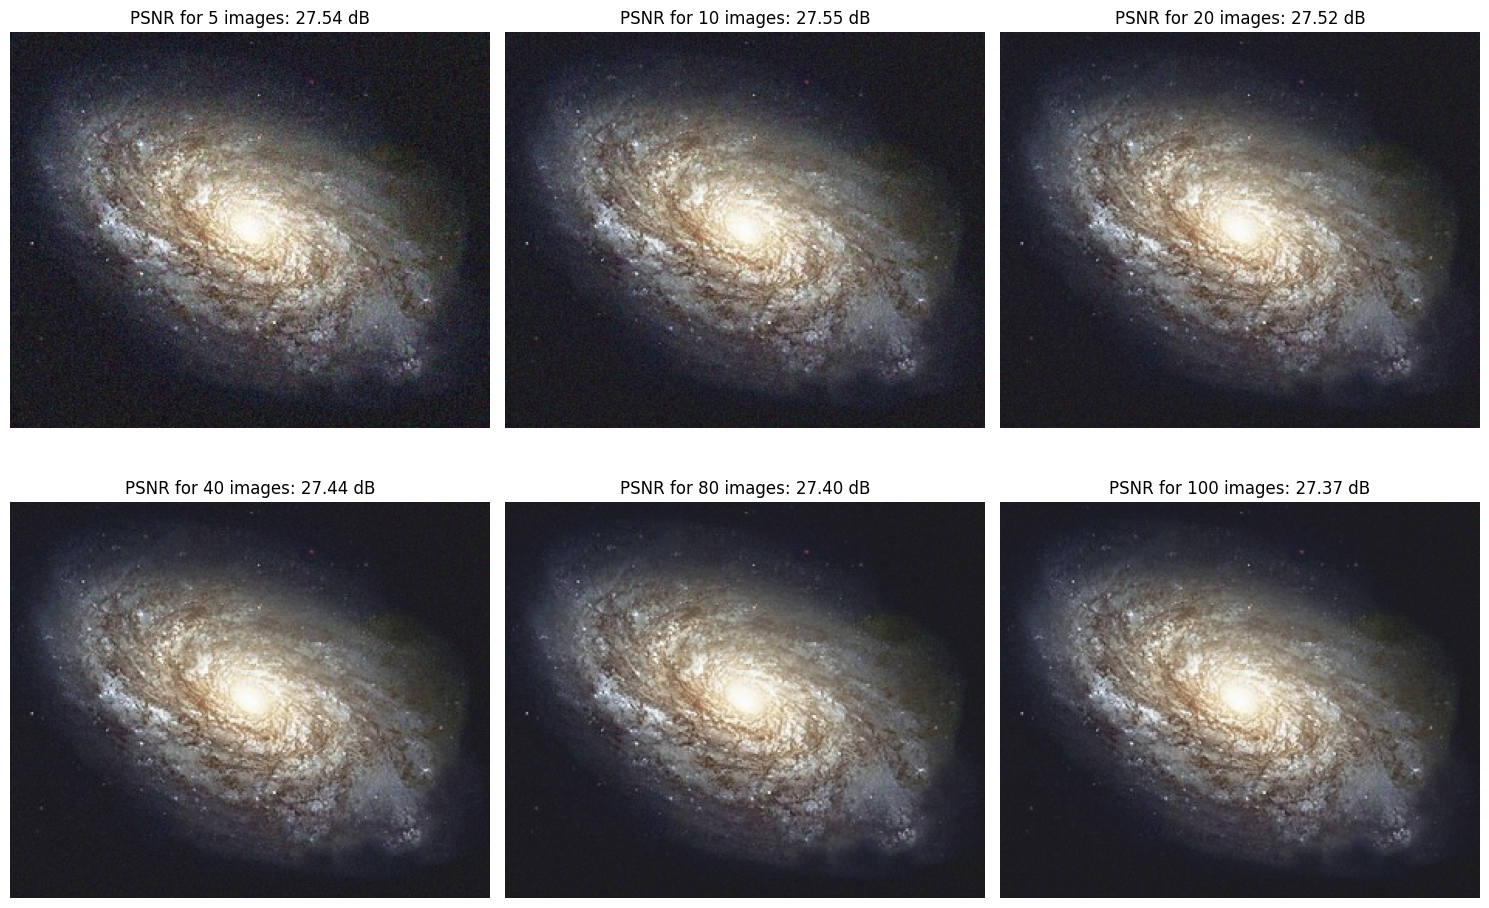

In [15]:
import glob
from math import log10, sqrt

# Fungsi untuk menghitung PSNR
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:  # Jika tidak ada perbedaan
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

# Fungsi untuk average denoising
def average_denoising(cv_img, num_images):
    # Membatasi jumlah gambar
    images = cv_img[:num_images]

    # Mendapatkan dimensi gambar
    h, w, c = images[0].shape

    # Inisialisasi array kosong untuk menyimpan hasil penjumlahan pixel
    average_img = np.zeros((h, w, c), np.float32)

    # Menambahkan semua gambar ke dalam array average_img
    for img in images:
        average_img += img.astype(np.float32)

    # Membagi total nilai pixel dengan jumlah gambar untuk mendapatkan rata-rata
    average_img /= len(images)

    # Konversi gambar kembali ke tipe uint8
    return np.clip(average_img, 0, 255).astype(np.uint8)

# Membaca semua gambar dari direktori
cv_img = []
for img in glob.glob('/content/drive/MyDrive/Images/noises/*.jpg'):
    n = cv.imread(img)
    cv_img.append(n)

# Membaca gambar asli (tanpa noise)
original = cv.imread('/content/drive/MyDrive/Images/galaxy.jpg')

# Daftar ukuran batch gambar yang ingin diuji
image_counts = [5, 10, 20, 40, 80, 100]

# Menampilkan hasil denoising dan nilai PSNR menggunakan matplotlib
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()  # Flatten the 2D array of axes into a 1D array for easier indexing

for i, count in enumerate(image_counts):
    # Melakukan average denoising dengan sejumlah gambar
    denoised_img = average_denoising(cv_img, count)
    psnr_value = calculate_psnr(original, denoised_img)

    # Menampilkan gambar dan nilai PSNR di plt
    axs[i].imshow(cv.cvtColor(denoised_img, cv.COLOR_BGR2RGB))
    axs[i].set_title(f"PSNR for {count} images: {psnr_value:.2f} dB")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

- Kualitas Denoising:

  Semakin banyak gambar yang digunakan untuk average denoising, umumnya kualitas hasil denoising akan meningkat. Hal ini karena teknik average denoising mengurangi noise dengan cara merata-rata nilai pixel dari beberapa gambar, sehingga mengurangi fluktuasi yang disebabkan oleh noise.

- PSNR:

  Nilai PSNR akan meningkat seiring bertambahnya jumlah gambar. PSNR yang lebih tinggi menunjukkan bahwa citra yang dihasilkan lebih dekat dengan citra asli (ground truth) setelah proses denoising, sehingga menunjukkan kinerja yang lebih baik.

### **4. Image Masking**

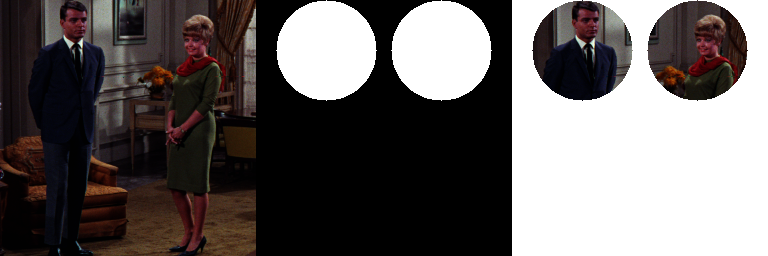

In [24]:
# Membaca gambar asli
original = cv.imread('/content/drive/MyDrive/Images/couple.tiff')

# Membuat mask dengan bentuk lingkaran
mask = np.zeros(original.shape, original.dtype)  # mask hanya di satu channel (grayscale)
cv.circle(mask, (70,50), 50, (255,255,255), -1)
cv.circle(mask, (185,50), 50, (255,255,255), -1)

# Menerapkan mask pada gambar
masked_image = cv.bitwise_and(original, mask)
masked_image[np.all(masked_image == [0, 0, 0], axis=-1)] = [255, 255, 255]

# Menampilkan gambar asli, mask, dan gambar yang di-mask
final_frame = cv.hconcat([original, mask, masked_image])

# Menampilkan hasilnya
cv2_imshow(final_frame)


### **5. Percobaan dengan beberapa operator**

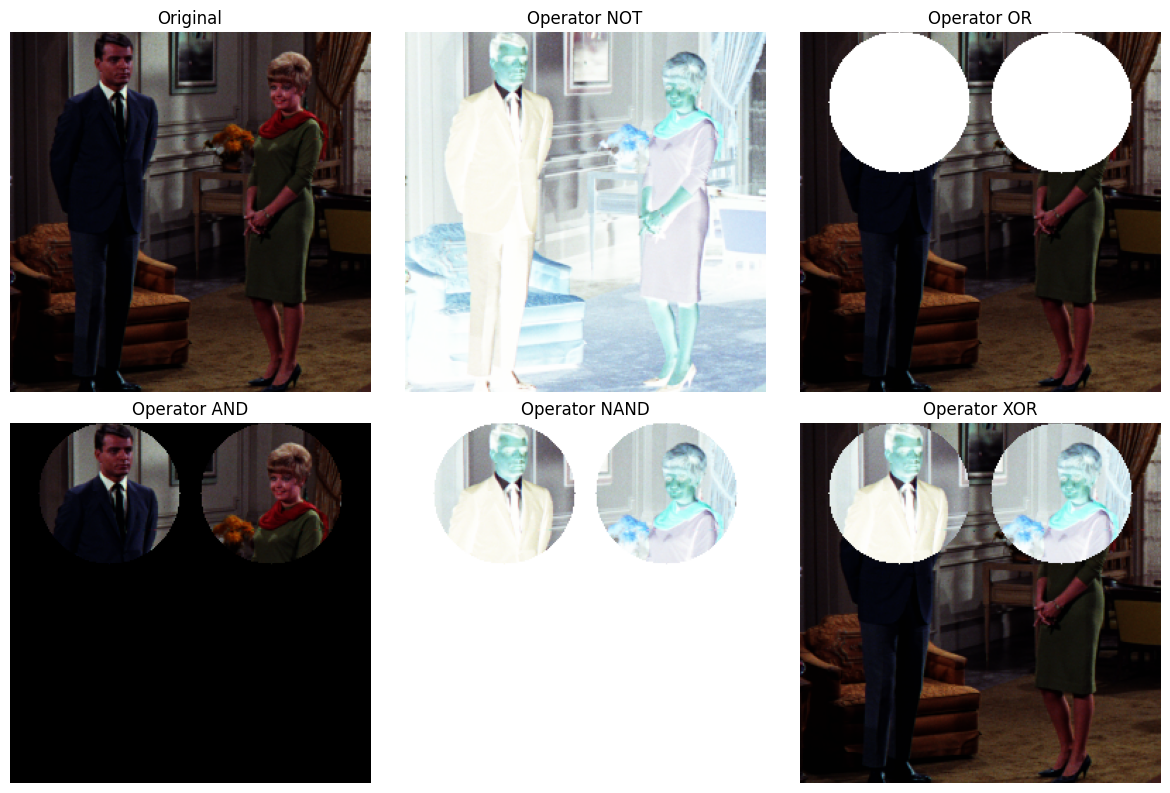

In [19]:
masked_image_not = cv.bitwise_not(original)
masked_image_or = cv.bitwise_or(original, mask)
masked_image_and = cv.bitwise_and(original, mask)
masked_image_nand = cv.bitwise_not(masked_image_and)
masked_image_xor = cv.bitwise_xor(original, mask)

# Fungsi untuk menampilkan gambar dalam plt
def show_images_with_titles(images, titles):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(2, 3, i + 1)
        plt.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')  # Menghilangkan axis

    plt.show()

# Daftar gambar yang ingin ditampilkan
images = [original, masked_image_not, masked_image_or, masked_image_and, masked_image_nand, masked_image_xor]
titles = ['Original', 'Operator NOT', 'Operator OR', 'Operator AND', 'Operator NAND', 'Operator XOR']

# Menampilkan gambar dan judul
show_images_with_titles(images, titles)

## **Tugas Kelompok**

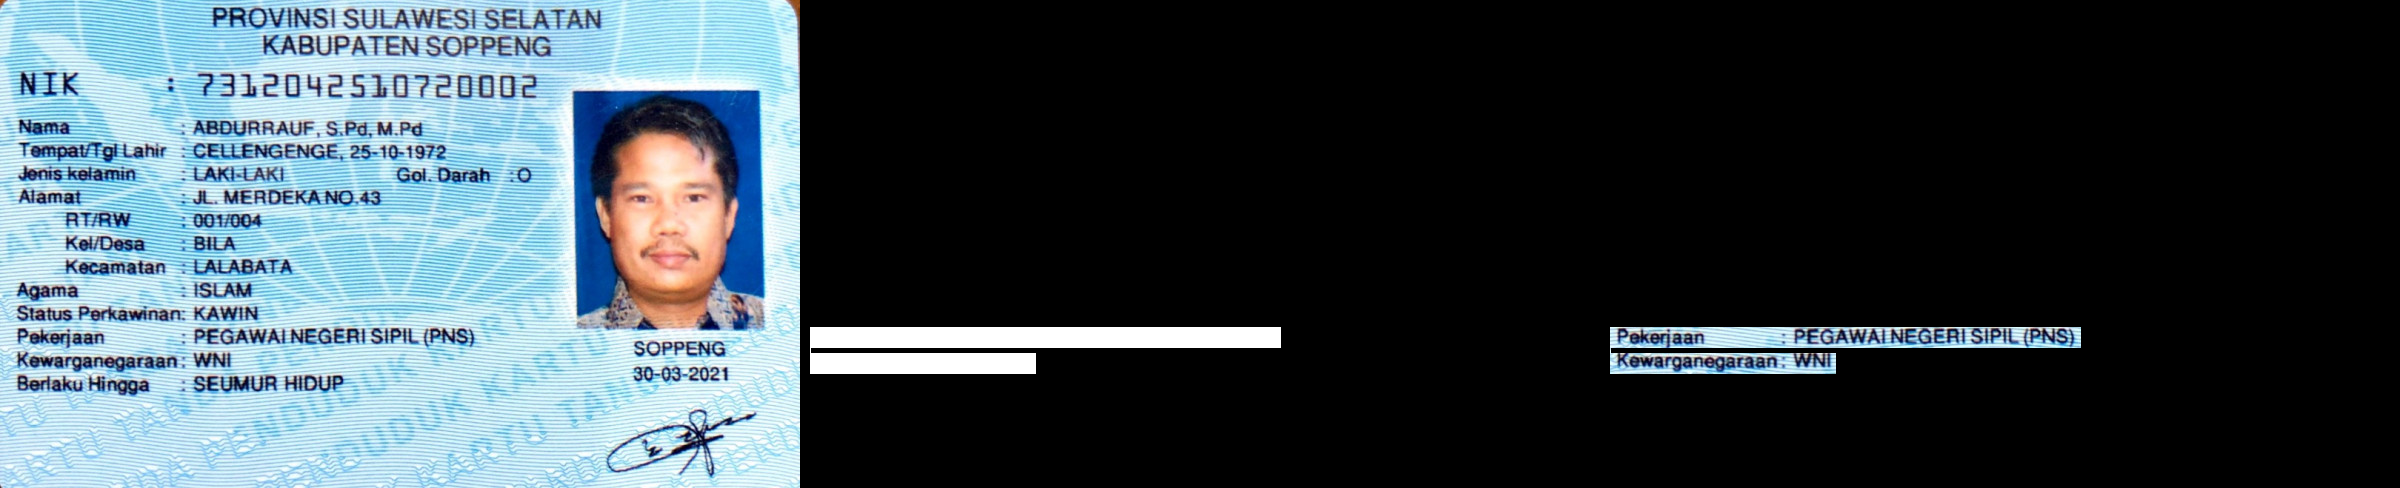

In [30]:
# Membaca gambar asli
ktp = cv.imread('KTP.jpeg.jpg')

# Membuat mask dengan bentuk lingkaran
mask = np.zeros(ktp.shape, ktp.dtype)  # mask hanya di satu channel (grayscale)
points1 = np.array([[10,327],[480,327],[480,347],[10,347],[10,353],[235,353],[235,373],[10,373]], dtype=np.int32)
pts1 = points1.reshape((-1, 1, 2))
cv.fillPoly(mask, [pts1], color=(255,255,255))

# Menerapkan mask pada gambar
masked_image = cv.bitwise_and(ktp, mask)

# Menampilkan gambar asli, mask, dan gambar yang di-mask
final_frame = cv.hconcat([ktp, mask, masked_image])

# Menampilkan hasilnya
cv2_imshow(final_frame)